## Team Members: Quinn Caton, Sai Prakash Chinnamsetti, Alex Joseph Norris, Venkata Sai Veeramala


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data import and preprocessing

In [ ]:
data = pd.read_csv('spam.csv')
ps = PorterStemmer()

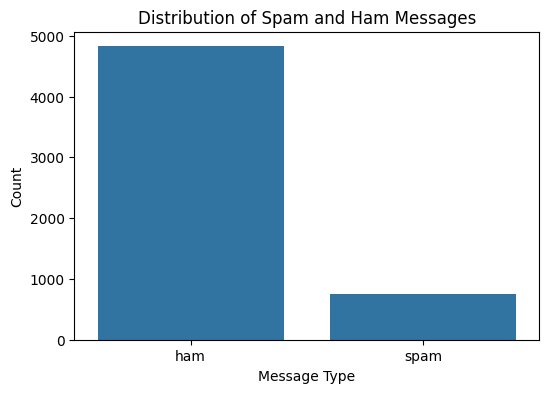

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='v1', data=data)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

In [ ]:
def preprocess_text(text):
    """
    Preprocesses the given text by converting to lowercase, removing non-alphabetic characters,
    tokenizing, stemming, and removing stopwords.
    Returns a list of preprocessed words.
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = word_tokenize(text)
    for w in words:
      w = ps.stem(w)
    words = [word for word in words if word not in stopwords.words('english')]
    return words

In [ ]:
# Apply preprocessing
data['tokens'] = data['v2'].apply(preprocess_text)

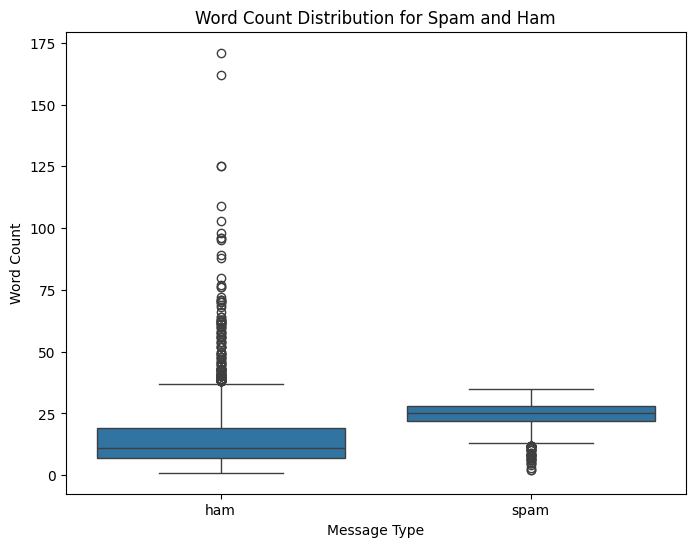

In [ ]:
data['word_count'] = data['v2'].apply(lambda text: len(text.split()))
plt.figure(figsize=(8, 6))
sns.boxplot(x='v1', y='word_count', data=data)
plt.title('Word Count Distribution for Spam and Ham')
plt.xlabel('Message Type')
plt.ylabel('Word Count')
plt.show()

In [ ]:
def filter_pos(tokens, target_pos):
    """
    Filters the given tokens based on the specified part-of-speech (POS) tag.
    Returns a list of words that match the specified POS.
    """
    tagged = pos_tag(tokens)
    return [word for word, pos in tagged if pos.startswith(target_pos)]

In [ ]:
# Create different feature sets
data['nouns'] = data['tokens'].apply(lambda x: filter_pos(x, 'NN'))
data['verbs'] = data['tokens'].apply(lambda x: filter_pos(x, 'VB'))

In [ ]:
data.head()

,v1,v2,tokens,nouns,verbs
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...","[point, crazy, bugis, world, la, cine]","[go, e, got]"
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[joking, wif, oni]",[]
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,...","[entry, comp, win, tkts, st, entry, question, ...","[wkly, cup, text, std, apply]"
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]","[dun, hor, c]","[say, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goes, usf, lives, around, though]","[think, lives]",[goes]


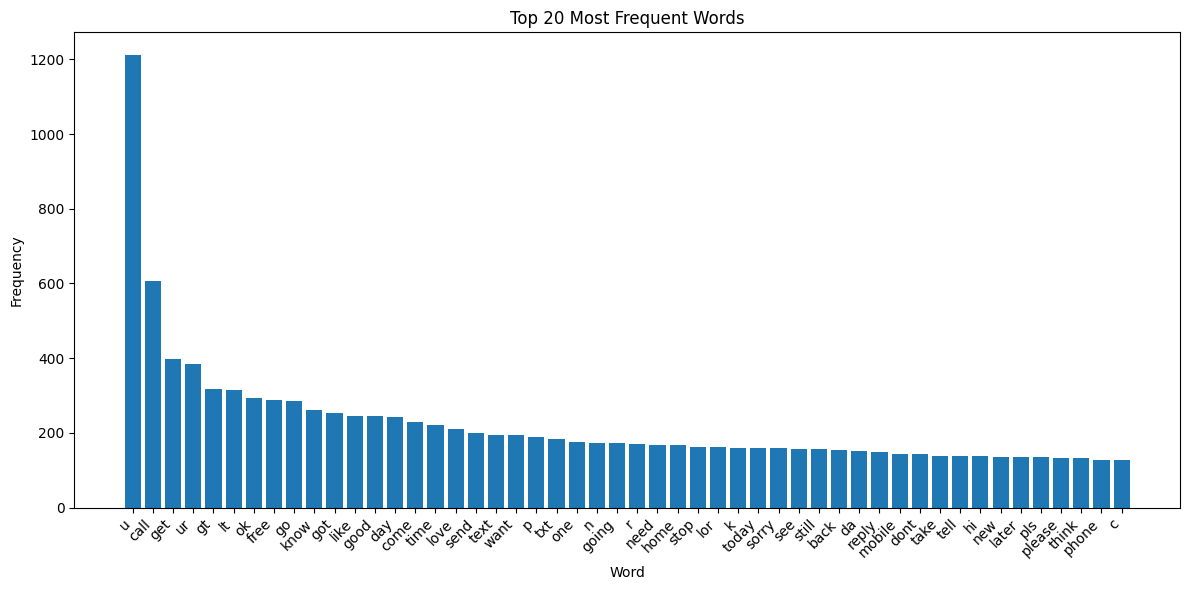

In [ ]:
all_words = [word for tokens in data['tokens'] for word in tokens]
word_counts = Counter(all_words)
top_words = word_counts.most_common(50)  # Get top 20 words

plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words))  # Unzip the list of tuples
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Q1: Calculating surprise/information, entropy, cross-entropy, and KL divergence

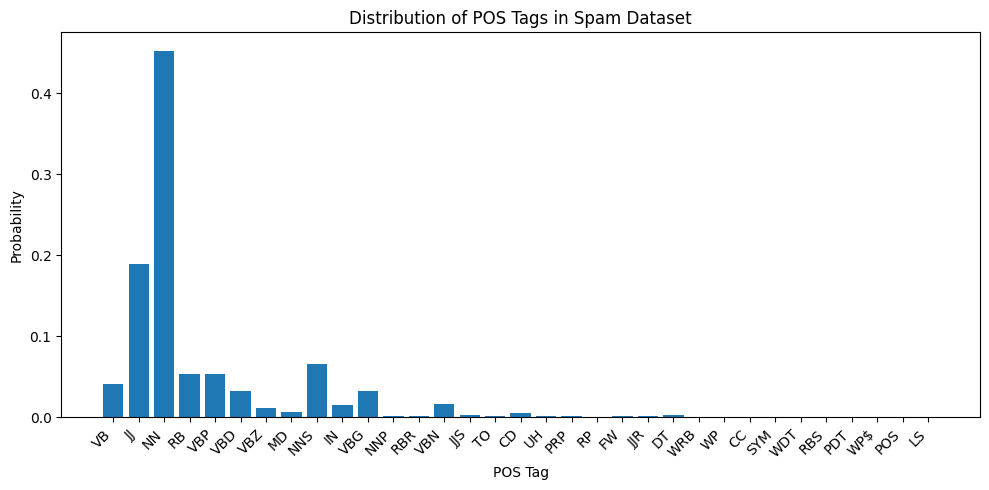

In [ ]:
# Compute POS distribution for Q

# extract POS tags from 'tokens' column
all_tags = [tag for tokens in data['tokens'] for _, tag in pos_tag(tokens)]
tag_counts = Counter(all_tags)
total_tags = sum(tag_counts.values())

# calculate probabilities for each POS tag
pos_probabilities = {tag: count / total_tags for tag, count in tag_counts.items()}

plt.figure(figsize=(10, 5))
plt.bar(pos_probabilities.keys(), pos_probabilities.values())
plt.title('Distribution of POS Tags in Spam Dataset')
plt.xlabel('POS Tag')
plt.ylabel('Probability')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Define P based on given probabilities
P = np.array([0.441, 0.255, 0.172, 0.132])
labels = ['noun', 'verb', 'adv', 'adj']

In [ ]:
# Construct Q based on POS distribution in CSV dataset
Q = np.array([pos_probabilities.get('NN', 0), pos_probabilities.get('VB', 0),
              pos_probabilities.get('RB', 0), pos_probabilities.get('JJ', 0)])
Q /= Q.sum()  # Ensure Q is a valid probability distribution
Q

array([0.61355693, 0.05610794, 0.07328439, 0.25705074])

In [ ]:
# Calculating surprise/information
surprise = -np.log2(P)

# Entropy: H(P) = -Σ p(x) log p(x)
entropy_P = -np.sum(P * np.log2(P))

# Cross-Entropy: H(P, Q) = -Σ p(x) log q(x)
cross_entropy = -np.sum(P * np.log2(Q))

# KL Divergence: D_KL(P || Q) = Σ p(x) log (p(x) / q(x))
kl_divergence = np.sum(P * np.log2(P / Q))

In [ ]:
print(f"P: {P}")
print(f"Q: {Q}")
print(f"Surprise (S): {surprise}")
print(f"Entropy (H(P)): {entropy_P:.4f}")
print(f"Cross-Entropy (H(P, Q)): {cross_entropy:.4f}")
print(f"KL Divergence (D_KL(P || Q)): {kl_divergence:.4f}")

P: [0.441 0.255 0.172 0.132]
Q: [0.61355693 0.05610794 0.07328439 0.25705074]
Surprise (S): [1.18114944 1.97143085 2.53951953 2.92139017]
Entropy (H(P)): 1.8460
Cross-Entropy (H(P, Q)): 2.2777
KL Divergence (D_KL(P || Q)): 0.4317


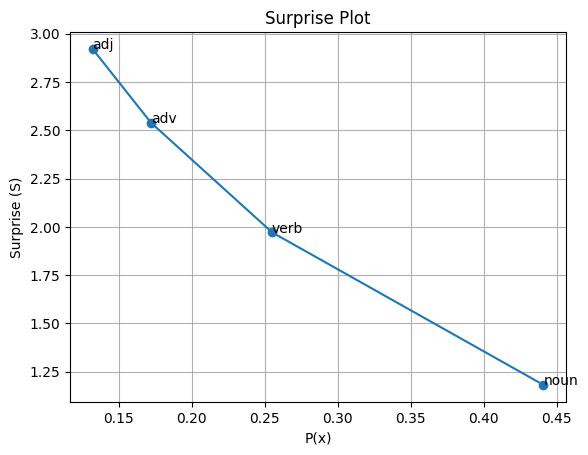

In [ ]:
plt.plot(P, surprise, marker='o')
for i, txt in enumerate(labels): # Add labels to the data points
    plt.annotate(txt, (P[i], surprise[i]))
plt.xlabel('P(x)')
plt.ylabel('Surprise (S)')
plt.title('Surprise Plot')
plt.grid(True)
plt.show()

#Q2 and Q3: Training Naive Bayes and Logistic models

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, model):
    """
    Trains the given model on the training data and evaluates it on the test data.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    else:
        roc_auc = None
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc
    }

In [ ]:
def check_overfitting(model, X_train, X_test, y_train, y_test):
    """
    Checks for overfitting by comparing training and test accuracy,
    as well as AUC scores.
    """
    # Evaluate on training data
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Evaluate on test data
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Check for overfitting
    if train_acc > test_acc + 0.1:
        print("⚠️ Warning: Possible overfitting detected!")

    # If the model supports probability estimates
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]

        train_auc = roc_auc_score(y_train, y_train_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)

        print(f"Training AUC: {train_auc:.4f}")
        print(f"Test AUC: {test_auc:.4f}")

        if train_auc > test_auc + 0.1:
            print("⚠️ Warning: Possible overfitting detected!")

In [ ]:
def vectorize_and_train(feature_column, results):
    """
    Vectorizes the specified feature column and trains Naive Bayes and Logistic Regression models.
    Stores the results in the provided dictionary.
    """
    vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, max_features=5000)
    X = vectorizer.fit_transform(data[feature_column])
    y = data['v1']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results[feature_column] = {}  # Ensure dictionary is initialized

    print()
    print(f'--- Training Naive Bayes for {feature_column} ---')
    nb_model = MultinomialNB()
    results[feature_column]['Naive Bayes'] = train_and_evaluate(X_train, X_test, y_train, y_test, nb_model)
    print(results[feature_column]['Naive Bayes'])

    check_overfitting(nb_model, X_train, X_test, y_train, y_test)

    print()
    print(f'--- Training Logistic Regression for {feature_column} ---')
    lr_model = LogisticRegression(max_iter=1000, C=0.1)
    results[feature_column]['Logistic Regression'] = train_and_evaluate(X_train, X_test, y_train, y_test, lr_model)
    print(results[feature_column]['Logistic Regression'])

    check_overfitting(lr_model, X_train, X_test, y_train, y_test)

In [ ]:
# Train models for 2 different feature sets
def vectorize_and_train_two(feature_column_1, feature_column_2, results):
    """
    Vectorizes the specified feature columns and trains Naive Bayes and Logistic Regression models.
    Stores the results in the provided dictionary.
    """
    vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
    X = vectorizer.fit_transform(data[feature_column_1] + data[feature_column_2])
    y = data['v1']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results[feature_column_1 + '&' + feature_column_2] = {}  # Ensure dictionary is initialized

    print()
    print(f'--- Training Naive Bayes for {feature_column_1} & {feature_column_2} ---')
    nb_model = MultinomialNB()
    results[feature_column_1 + '&' + feature_column_2]['Naive Bayes'] = train_and_evaluate(X_train, X_test, y_train, y_test, nb_model)
    print(results[feature_column_1 + '&' + feature_column_2]['Naive Bayes'])

    print()
    print(f'--- Training Logistic Regression for {feature_column_1} & {feature_column_2} ---')
    lr_model = LogisticRegression(max_iter=1000)
    results[feature_column_1 + '&' + feature_column_2]['Logistic Regression'] = train_and_evaluate(X_train, X_test, y_train, y_test, lr_model)
    print(results[feature_column_1 + '&' + feature_column_2]['Logistic Regression'])


--- Training Naive Bayes for tokens ---
Accuracy: 0.9775784753363229
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99       965
        spam       0.91      0.92      0.92       150

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
 [[952  13]
 [ 12 138]]
ROC-AUC Score: 0.9836165803108808


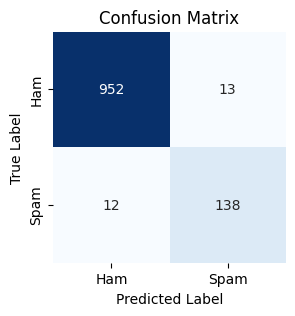

{'accuracy': 0.9775784753363229, 'roc_auc': 0.9836165803108808}
Training Accuracy: 0.9921
Test Accuracy: 0.9776
Training AUC: 0.9964
Test AUC: 0.9836

--- Training Logistic Regression for tokens ---
Accuracy: 0.9713004484304932
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       1.00      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[965   0]
 [ 32 118]]
ROC-AUC Score: 0.9890086355785838


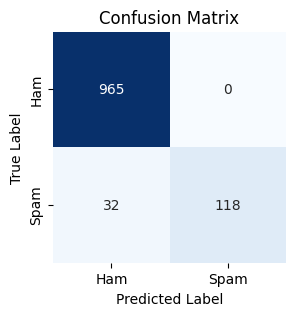

{'accuracy': 0.9713004484304932, 'roc_auc': 0.9890086355785838}
Training Accuracy: 0.9796
Test Accuracy: 0.9713
Training AUC: 0.9973
Test AUC: 0.9890

--- Training Naive Bayes for nouns ---
Accuracy: 0.9748878923766816
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.98      0.99       965
        spam       0.90      0.91      0.91       150

    accuracy                           0.97      1115
   macro avg       0.94      0.95      0.95      1115
weighted avg       0.98      0.97      0.97      1115

Confusion Matrix:
 [[950  15]
 [ 13 137]]
ROC-AUC Score: 0.9815094991364421


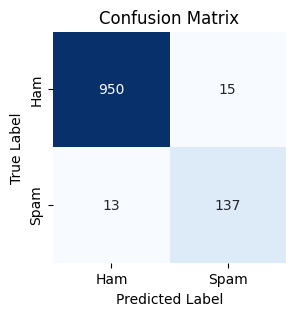

{'accuracy': 0.9748878923766816, 'roc_auc': 0.9815094991364421}
Training Accuracy: 0.9901
Test Accuracy: 0.9749
Training AUC: 0.9955
Test AUC: 0.9815

--- Training Logistic Regression for nouns ---
Accuracy: 0.947085201793722
Classification Report:
               precision    recall  f1-score   support

         ham       0.94      1.00      0.97       965
        spam       1.00      0.61      0.76       150

    accuracy                           0.95      1115
   macro avg       0.97      0.80      0.86      1115
weighted avg       0.95      0.95      0.94      1115

Confusion Matrix:
 [[965   0]
 [ 59  91]]
ROC-AUC Score: 0.9844663212435233


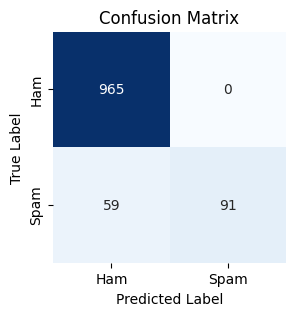

{'accuracy': 0.947085201793722, 'roc_auc': 0.9844663212435233}
Training Accuracy: 0.9560
Test Accuracy: 0.9471
Training AUC: 0.9932
Test AUC: 0.9845

--- Training Naive Bayes for verbs ---
Accuracy: 0.9354260089686098
Classification Report:
               precision    recall  f1-score   support

         ham       0.94      0.98      0.96       965
        spam       0.86      0.62      0.72       150

    accuracy                           0.94      1115
   macro avg       0.90      0.80      0.84      1115
weighted avg       0.93      0.94      0.93      1115

Confusion Matrix:
 [[950  15]
 [ 57  93]]
ROC-AUC Score: 0.8873264248704662


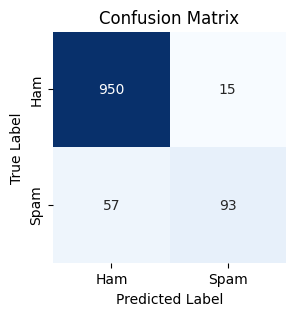

{'accuracy': 0.9354260089686098, 'roc_auc': 0.8873264248704662}
Training Accuracy: 0.9513
Test Accuracy: 0.9354
Training AUC: 0.9444
Test AUC: 0.8873

--- Training Logistic Regression for verbs ---
Accuracy: 0.8941704035874439
Classification Report:
               precision    recall  f1-score   support

         ham       0.89      1.00      0.94       965
        spam       1.00      0.21      0.35       150

    accuracy                           0.89      1115
   macro avg       0.95      0.61      0.65      1115
weighted avg       0.91      0.89      0.86      1115

Confusion Matrix:
 [[965   0]
 [118  32]]
ROC-AUC Score: 0.896770293609672


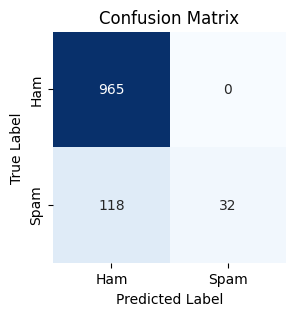

{'accuracy': 0.8941704035874439, 'roc_auc': 0.896770293609672}
Training Accuracy: 0.8887
Test Accuracy: 0.8942
Training AUC: 0.9336
Test AUC: 0.8968

--- Training Naive Bayes for verbs & nouns ---
Accuracy: 0.9730941704035875
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.98      0.98       965
        spam       0.88      0.92      0.90       150

    accuracy                           0.97      1115
   macro avg       0.94      0.95      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[947  18]
 [ 12 138]]
ROC-AUC Score: 0.9786390328151986


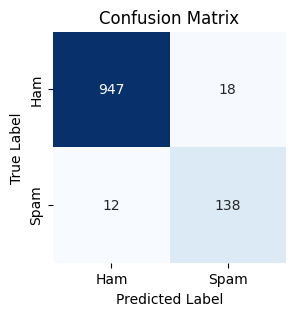

{'accuracy': 0.9730941704035875, 'roc_auc': 0.9786390328151986}

--- Training Logistic Regression for verbs & nouns ---
Accuracy: 0.9757847533632287
Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       1.00      0.82      0.90       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115

Confusion Matrix:
 [[965   0]
 [ 27 123]]
ROC-AUC Score: 0.9807564766839378


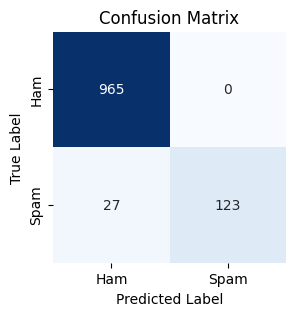

{'accuracy': 0.9757847533632287, 'roc_auc': 0.9807564766839378}


In [ ]:

results = {}
vectorize_and_train('tokens', results)  # Baseline
vectorize_and_train('nouns', results)   # Noun-only
vectorize_and_train('verbs', results)   # Verb-only
vectorize_and_train_two('verbs', 'nouns', results)   # Verbs and Nouns

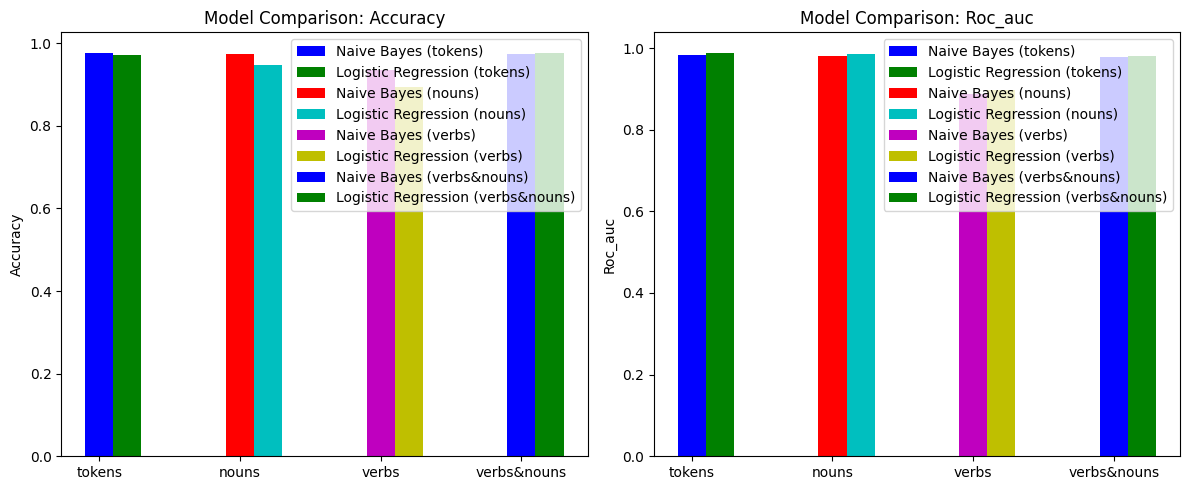

In [ ]:
# Plot performance comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
metrics = ['accuracy', 'roc_auc']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

for i, metric in enumerate(metrics):
    for j, (feature, models) in enumerate(results.items()):
        for k, (model_name, scores) in enumerate(models.items()):
            if scores[metric] is not None:
                ax[i].bar(j + (0.2 * k), scores[metric], width=0.2, label=f'{model_name} ({feature})', color=colors[(j * len(models) + k) % len(colors)])
    ax[i].set_xticks(range(len(results)))
    ax[i].set_xticklabels(results.keys())
    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_title(f'Model Comparison: {metric.capitalize()}')
    ax[i].legend()

plt.tight_layout()
plt.show()